In [3]:
import cv2
import pandas as pd
import numpy as np
from ultralytics import YOLO
import os
import argparse
from tqdm import tqdm

In [ ]:
def train_model(model_name = "yolov8n.pt", modell = None, data_path ="/content/dataset/data.yaml"  ):
    if modell is None:
        model = YOLO(model_name)
    else:
        model = modell
        if 'model' not in model.overrides:
            model.overrides['model'] = model_name


    # Train the model
    results = model.train(
        data=data_path,
        epochs=100,
        imgsz=1280,
        batch=16,
        project = "/content/drive/MyDrive/Edgefleet_Assessment/models",
        name="cricket_ball_v26",

        # --- Overfitting Controls ---
        patience=10,           # Stop if no improvement for 10 epochs (Prevents Overfitting)
        dropout=0.05,           # Use 0.1 or 0.2 if your dataset is very small (<500 images)
        optimizer='AdamW',     # Generally more stable than SGD for small datasets
        lr0 = 0.001,
        lrf=0.01,
        augment=True,          # Ensure augmentation is on
        mosaic=0.0,
        # blur=0.1,
        # box=7.5,
        device=0,
    )

    return model

# model = train_model(data_path ="/content/dataset2/data.yaml")

In [5]:
model = train_model(model_name = "yolov8s.pt", data_path="/content/dataset/data.yaml")

Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.05, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=0.0, multi_scale=False, name=cricket_ball_v265, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=10, perspective=0.0, plots=Tr

In [ ]:
import glob

import random
import matplotlib.pyplot as plt

def validate_and_visualize(model_path, test_images_path):
    # 1. DEFINE PATHS
    # Based on your training code, the model is saved here:
    # model_path = "/content/drive/MyDrive/Edgefleet_Assessment/models/cricket_ball_v2/weights/best.pt"

    # # Path to your test images (Update this if your folder structure is different)
    # test_images_path = "/content/dataset/test/images"

    # Check if model exists
    if not os.path.exists(model_path):
        print(f"Error: Model not found at {model_path}. Did training finish?")
        return

    # Load the best trained model
    best_model = YOLO(model_path)

    print("--- 1. Running Quantitative Evaluation (mAP scores) ---")
    # This runs the model on the 'test' split defined in data.yaml and gives you mAP scores
    metrics = best_model.val(split='test', verbose=True)
    print(f"mAP@50: {metrics.box.map50:.3f}")
    print(f"mAP@50-95: {metrics.box.map:.3f}")

    print("\n--- 2. Generating Visual Predictions ---")

    # Get all images from the test folder
    # Extensions to look for: .jpg, .jpeg, .png
    image_files = glob.glob(os.path.join(test_images_path, "*.jpg")) + \
                  glob.glob(os.path.join(test_images_path, "*.jpeg")) + \
                  glob.glob(os.path.join(test_images_path, "*.png"))

    if not image_files:
        print("No images found in test path!")
        return

    # Select 6 random images to display
    num_samples = min(6, len(image_files))
    selected_images = random.sample(image_files, num_samples)

    # Run inference on selected images
    results = best_model.predict(selected_images, conf=0.25)

    # Setup Matplotlib grid
    plt.figure(figsize=(15, 10))

    for i, result in enumerate(results):
        # Plot the result (draws boxes on the image)
        # numpy() converts it to an array we can display
        img_with_boxes = result.plot()

        # Convert BGR (OpenCV/YOLO default) to RGB (Matplotlib default)
        img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

        # Add to subplot
        plt.subplot(2, 3, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Prediction {i+1}")

    plt.tight_layout()
    plt.show()

# Run the function
# somthing just like this

--- 1. Running Quantitative Evaluation (mAP scores) ---
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 15.4±1.7 MB/s, size: 36.7 KB)
val: Scanning /content/dataset/test/labels.cache... 125 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 125/125 224.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 1.0s/it 8.3s
                   all        125        170      0.661      0.694      0.659      0.187
Speed: 18.5ms preprocess, 32.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /content/runs/detect/val4
mAP@50: 0.659
mAP@50-95: 0.187

--- 2. Generating Visual Predictions ---

0: 1280x1280 1 ball, 38.9ms
1: 1280x1280 2 balls, 38.9ms
2: 1280x1280 1 ball, 38.9ms
3: 1280x1280 1 ball, 38.9ms
4: 1280x1280 2 balls, 38.9ms
5: 1280x12

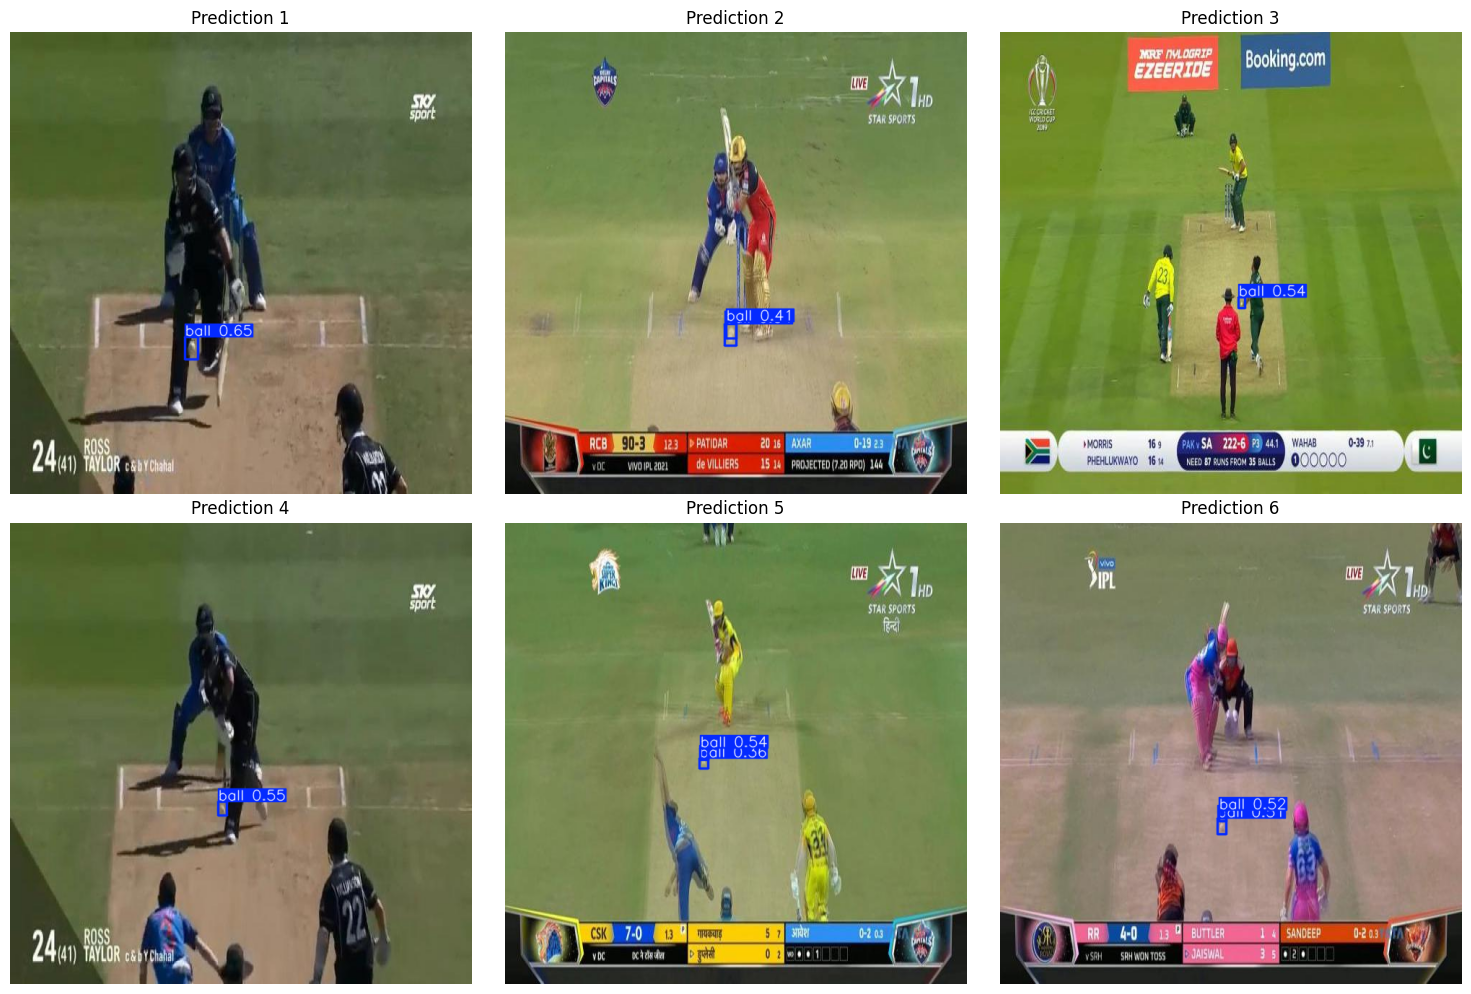

In [ ]:
model = YOLO("/content/drive/MyDrive/Edgefleet_Assessment/models/cricket_ball_v25/weights/best.pt")
validate_and_visualize("/content/drive/MyDrive/Edgefleet_Assessment/models/cricket_ball_v25/weights/best.pt","/content/dataset/test/images" )

In [6]:
from typing import List, Optional
from scipy.signal import savgol_filter



def filter_points(init_detections):
    """
    Finds the longest valid sequence of points using Dynamic Programming.
    dp[i] = (length, prev_index) where length is the longest path ending at i
    """
    n = len(init_detections)

    # Filter to only visible detections with their original indices
    visible = [(i, det) for i, det in enumerate(init_detections) if det["visible"] == 1]

    if not visible:
        return [{
            "frame": det["frame"],
            "x": -1.0, "y": -1.0, "visible": 0
        } for det in init_detections]

    # DP table: dp[i] = (max_length_ending_here, previous_index_in_visible_array)
    dp = [(1, -1) for _ in range(len(visible))]

    # Build DP table
    for i in range(1, len(visible)):
        curr_idx, curr_det = visible[i]

        for j in range(i):
            prev_idx, prev_det = visible[j]

            # Check motion constraints
            dx = abs(curr_det["x"] - prev_det["x"])
            dy = abs(curr_det["y"] - prev_det["y"])

            if (1 < dx < 60 or 1 < dy < 60) and (dx < 200 and dy < 200):
                # Valid transition from j to i
                if dp[j][0] + 1 > dp[i][0]:
                    dp[i] = (dp[j][0] + 1, j)

    # Find the ending point of the longest sequence
    max_length = 0
    max_end_idx = 0
    for i, (length, _) in enumerate(dp):
        if length > max_length:
            max_length = length
            max_end_idx = i

    # Backtrack to reconstruct the path
    path_indices = []
    curr = max_end_idx
    while curr != -1:
        path_indices.append(visible[curr][0])  # Original index
        curr = dp[curr][1]

    path_indices.reverse()
    valid_set = set(path_indices)

    # Build filtered output
    filtered_data = []
    for i, det in enumerate(init_detections):
        if i in valid_set:
            filtered_data.append(det)
        else:
            filtered_data.append({
                "frame": det["frame"],
                "x": -1.0, "y": -1.0, "visible": 0
            })

    return filtered_data


def smooth_trajectory(csv_data, window=9, poly=2):
    xs, ys, frames = [], [], []

    for d in csv_data:
        if d["visible"] == 1:
            xs.append(d["x"])
            ys.append(d["y"])
            frames.append(d["frame"])

    if len(xs) < window:
        return csv_data  # Not enough points

    xs_s = savgol_filter(xs, window_length=window, polyorder=poly)
    ys_s = savgol_filter(ys, window_length=window, polyorder=poly)

    idx = 0
    for d in csv_data:
        if d["visible"] == 1:
            d["x"] = float(xs_s[idx])
            d["y"] = float(ys_s[idx])
            idx += 1

    return csv_data

def kalman_smooth(csv_data):
    kf = cv2.KalmanFilter(4, 2)
    kf.measurementMatrix = np.array([[1,0,0,0],[0,1,0,0]], np.float32)
    kf.transitionMatrix  = np.array([[1,0,1,0],
                                     [0,1,0,1],
                                     [0,0,1,0],
                                     [0,0,0,1]], np.float32)
    kf.processNoiseCov   = np.eye(4, dtype=np.float32) * 0.03

    for d in csv_data:
        if d["visible"] == 1:
            meas = np.array([[np.float32(d["x"])],
                             [np.float32(d["y"])]])
            kf.correct(meas)

        pred = kf.predict()
        d["x"], d["y"] = float(pred[0]), float(pred[1])
        d["visible"] = 1

    return csv_data

def process_video(
    video_path: str,
    model_path: str,
    output_video_dir: str,
    output_csv_dir: str,
    target_class_id: int = 0,
    conf_threshold: float = 0.1,
    trace_length: Optional[int] = None
):
    model = YOLO(model_path)
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    filename_base = os.path.splitext(os.path.basename(video_path))[0]
    os.makedirs(output_video_dir, exist_ok=True)
    os.makedirs(output_csv_dir, exist_ok=True)

    # 2. First Pass: Get all raw detections
    init_detections = []
    frames_buffer = []

    print(f"Pass 1: Detecting objects in {filename_base}...")
    for frame_idx in tqdm(range(total_frames)):
        ret, frame = cap.read()
        if not ret: break

        frames_buffer.append(frame)

        results = model.predict(frame, conf=conf_threshold, imgsz=2560, verbose=False, classes=[target_class_id])

        cx, cy, detected = -1.0, -1.0, False
        if results and len(results[0].boxes) > 0:
            best_box = max(results[0].boxes, key=lambda x: x.conf[0])
            x_raw, y_raw, _, _ = best_box.xywh[0].cpu().numpy()
            cx, cy, detected = float(x_raw), float(y_raw), True

        init_detections.append({
            "frame": frame_idx, "x": round(cx, 1), "y": round(cy, 1), "visible": 1 if detected else 0
        })

    # 3. Filter Pass: Select the "True" Path
    print("Pass 2: Filtering trajectory...")
    csv_data = filter_points(init_detections)
    csv_data = smooth_trajectory(csv_data)
    # csv_data = kalman_smooth(csv_data)

    # 4. Final Pass: Draw and Write Video
    print("Pass 3: Rendering video...")
    save_video_path = os.path.join(output_video_dir, f"{filename_base}_processed.mp4")
    out = cv2.VideoWriter(save_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    trajectory_points = []
    for i, det in enumerate(csv_data):
        frame = frames_buffer[i]

        if det["visible"] == 1:
            curr_pt = (int(det["x"]), int(det["y"]))
            trajectory_points.append(curr_pt)

            # Draw Ball and Label
            cv2.circle(frame, curr_pt, 5, (0, 0, 255), -1)
            cv2.putText(frame, f"F:{det['frame']}", (curr_pt[0]+10, curr_pt[1]),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Draw Trajectory Line
        if len(trajectory_points) > 1:
            pts = np.array(trajectory_points, np.int32).reshape((-1, 1, 2))
            cv2.polylines(frame, [pts], isClosed=False, color=(0, 255, 255), thickness=2)

        out.write(frame)

    # 5. Cleanup
    cap.release()
    out.release()
    pd.DataFrame(csv_data).to_csv(os.path.join(output_csv_dir, f"{filename_base}.csv"), index=False)
    print(f"Finished! Output at {save_video_path}")




In [7]:
def process_video_directory(
    video_dir,
    model_path,
    output_video_dir,
    output_csv_dir,
    video_exts=(".mp4", ".mov")
):
    for file in sorted(os.listdir(video_dir)):
        if file.lower().endswith(video_exts):
            video_path = os.path.join(video_dir, file)
            print(f"Processing {file}...")

            process_video(
                video_path,
                model_path,
                output_video_dir,
                output_csv_dir
            )

In [8]:
process_video_directory("/content/drive/MyDrive/Colab Notebooks/Edgefleet_Assessment/25_nov_2025", "/content/drive/MyDrive/Edgefleet_Assessment/models/cricket_ball_v265/weights/best.pt", "/content/drive/MyDrive/Edgefleet_Assessment/models/cricket_ball_v265", "/content/drive/MyDrive/Edgefleet_Assessment/models/cricket_ball_v265")

Processing 1.mp4...
Pass 1: Detecting objects in 1...


100%|██████████| 31/31 [00:03<00:00,  9.05it/s]


Pass 2: Filtering trajectory...
Pass 3: Rendering video...
Finished! Output at /content/drive/MyDrive/Edgefleet_Assessment/models/cricket_ball_v265/1_processed.mp4
Processing 10.mov...
Pass 1: Detecting objects in 10...


100%|█████████▉| 201/202 [00:49<00:00,  4.08it/s]


Pass 2: Filtering trajectory...
Pass 3: Rendering video...
Finished! Output at /content/drive/MyDrive/Edgefleet_Assessment/models/cricket_ball_v265/10_processed.mp4
Processing 11.mov...
Pass 1: Detecting objects in 11...


100%|██████████| 177/177 [00:20<00:00,  8.67it/s]


Pass 2: Filtering trajectory...
Pass 3: Rendering video...
Finished! Output at /content/drive/MyDrive/Edgefleet_Assessment/models/cricket_ball_v265/11_processed.mp4
Processing 12.mov...
Pass 1: Detecting objects in 12...


 99%|█████████▉| 138/139 [00:13<00:00, 10.26it/s]


Pass 2: Filtering trajectory...
Pass 3: Rendering video...
Finished! Output at /content/drive/MyDrive/Edgefleet_Assessment/models/cricket_ball_v265/12_processed.mp4
Processing 13.mov...
Pass 1: Detecting objects in 13...


100%|██████████| 178/178 [00:18<00:00,  9.88it/s]


Pass 2: Filtering trajectory...
Pass 3: Rendering video...
Finished! Output at /content/drive/MyDrive/Edgefleet_Assessment/models/cricket_ball_v265/13_processed.mp4
Processing 14.mov...
Pass 1: Detecting objects in 14...


100%|██████████| 196/196 [00:23<00:00,  8.29it/s]


Pass 2: Filtering trajectory...
Pass 3: Rendering video...
Finished! Output at /content/drive/MyDrive/Edgefleet_Assessment/models/cricket_ball_v265/14_processed.mp4
Processing 15.mov...
Pass 1: Detecting objects in 15...


 99%|█████████▉| 178/179 [00:17<00:00,  9.93it/s]


Pass 2: Filtering trajectory...
Pass 3: Rendering video...
Finished! Output at /content/drive/MyDrive/Edgefleet_Assessment/models/cricket_ball_v265/15_processed.mp4
Processing 2.mov...
Pass 1: Detecting objects in 2...


100%|██████████| 293/293 [00:40<00:00,  7.19it/s]


Pass 2: Filtering trajectory...
Pass 3: Rendering video...
Finished! Output at /content/drive/MyDrive/Edgefleet_Assessment/models/cricket_ball_v265/2_processed.mp4
Processing 3.mov...
Pass 1: Detecting objects in 3...


100%|██████████| 262/262 [00:42<00:00,  6.19it/s]


Pass 2: Filtering trajectory...
Pass 3: Rendering video...
Finished! Output at /content/drive/MyDrive/Edgefleet_Assessment/models/cricket_ball_v265/3_processed.mp4
Processing 4.mov...
Pass 1: Detecting objects in 4...


100%|██████████| 265/265 [00:48<00:00,  5.50it/s]


Pass 2: Filtering trajectory...
Pass 3: Rendering video...
Finished! Output at /content/drive/MyDrive/Edgefleet_Assessment/models/cricket_ball_v265/4_processed.mp4
Processing 5.mov...
Pass 1: Detecting objects in 5...


100%|█████████▉| 243/244 [00:42<00:00,  5.71it/s]


Pass 2: Filtering trajectory...
Pass 3: Rendering video...
Finished! Output at /content/drive/MyDrive/Edgefleet_Assessment/models/cricket_ball_v265/5_processed.mp4
Processing 6.mov...
Pass 1: Detecting objects in 6...


100%|██████████| 361/361 [00:53<00:00,  6.79it/s]


Pass 2: Filtering trajectory...
Pass 3: Rendering video...
Finished! Output at /content/drive/MyDrive/Edgefleet_Assessment/models/cricket_ball_v265/6_processed.mp4
Processing 7.mov...
Pass 1: Detecting objects in 7...


100%|█████████▉| 237/238 [00:36<00:00,  6.41it/s]


Pass 2: Filtering trajectory...
Pass 3: Rendering video...
Finished! Output at /content/drive/MyDrive/Edgefleet_Assessment/models/cricket_ball_v265/7_processed.mp4
Processing 8.mov...
Pass 1: Detecting objects in 8...


100%|██████████| 209/209 [00:26<00:00,  7.77it/s]


Pass 2: Filtering trajectory...
Pass 3: Rendering video...
Finished! Output at /content/drive/MyDrive/Edgefleet_Assessment/models/cricket_ball_v265/8_processed.mp4
Processing 9.mov...
Pass 1: Detecting objects in 9...


100%|█████████▉| 274/275 [00:48<00:00,  5.61it/s]


Pass 2: Filtering trajectory...
Pass 3: Rendering video...
Finished! Output at /content/drive/MyDrive/Edgefleet_Assessment/models/cricket_ball_v265/9_processed.mp4
